<a href="https://colab.research.google.com/github/angsor/PancreasImageClassification/blob/master/PancreasCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
## Example of a path

!ls "/content/drive/My Drive/PancreasCNN"

check2.jpg  check.jpg	      inflammationtrain  train
check3.jpg  inflammationtest  test


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np



In [48]:
image_size = (180, 180)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/PancreasCNN/train",
    validation_split=None,
    subset=None,
    seed=None,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/PancreasCNN/test",
    validation_split= None,
    subset=None,
    seed=None,
    image_size=image_size,
    batch_size=batch_size,
)


Found 104 files belonging to 2 classes.
Found 55 files belonging to 2 classes.


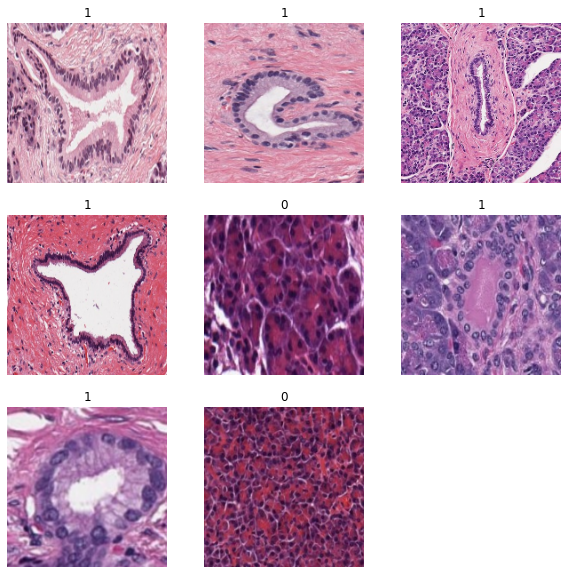

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [22]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


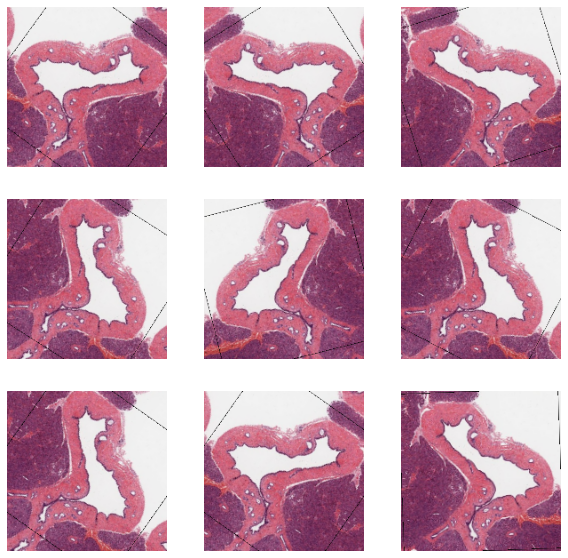

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [24]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)



In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

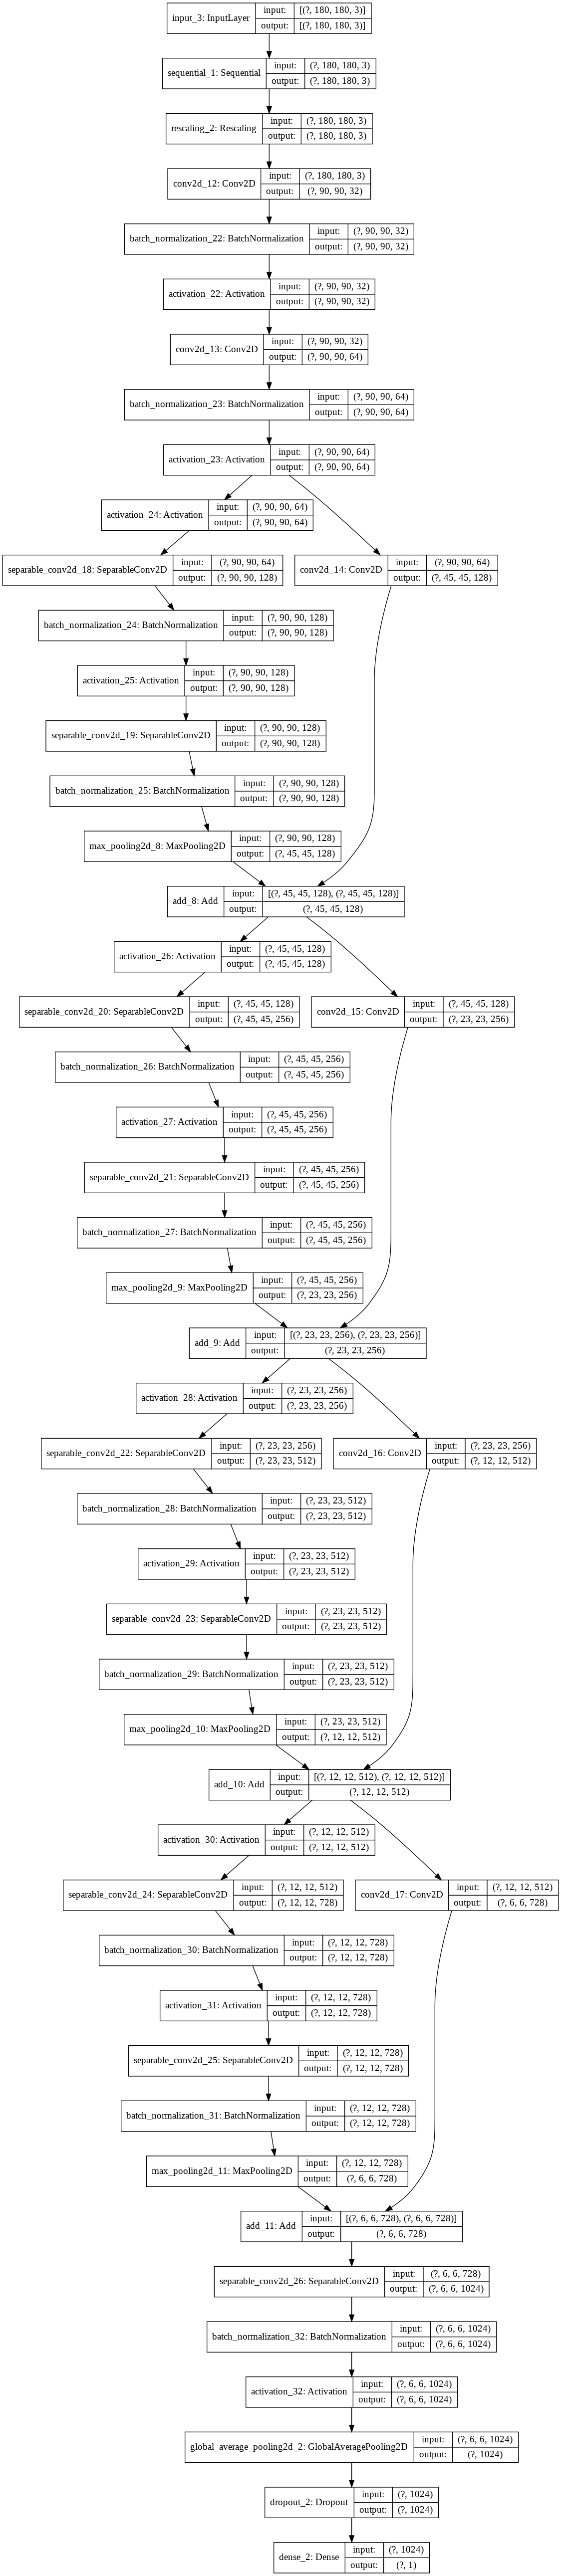

In [29]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [63]:
epochs = 100

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/100
13/13 [==============================] - 27s 2s/step - loss: 0.4557 - accuracy: 0.9135 - val_loss: 0.6956 - val_accuracy: 0.8545
Epoch 2/100
13/13 [==============================] - 27s 2s/step - loss: 0.2037 - accuracy: 0.9231 - val_loss: 0.2893 - val_accuracy: 0.9636
Epoch 3/100
13/13 [==============================] - 27s 2s/step - loss: 0.1912 - accuracy: 0.9519 - val_loss: 3.5319 - val_accuracy: 0.7818
Epoch 4/100
13/13 [==============================] - 27s 2s/step - loss: 0.0342 - accuracy: 0.9808 - val_loss: 1.7327 - val_accuracy: 0.8364
Epoch 5/100
13/13 [==============================] - 27s 2s/step - loss: 0.0804 - accuracy: 0.9712 - val_loss: 0.3778 - val_accuracy: 0.9273
Epoch 6/100
13/13 [==============================] - 27s 2s/step - loss: 0.0800 - accuracy: 0.9712 - val_loss: 0.1825 - val_accuracy: 0.9818
Epoch 7/100
13/13 [==============================] - 27s 2s/step - loss: 0.0757 - accuracy: 0.9712 - val_loss: 0.1855 - val_accuracy: 0.9636
Epoch 8/100
1

This image is 98.50 acinar and 1.50 percent duct.


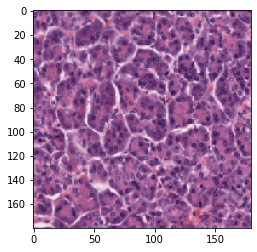

In [91]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/PancreasCNN/check4.png" , target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

plt.imshow(img)

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f acinar and %.2f percent duct."
    % (100 * (1 - score), 100 * score)
)




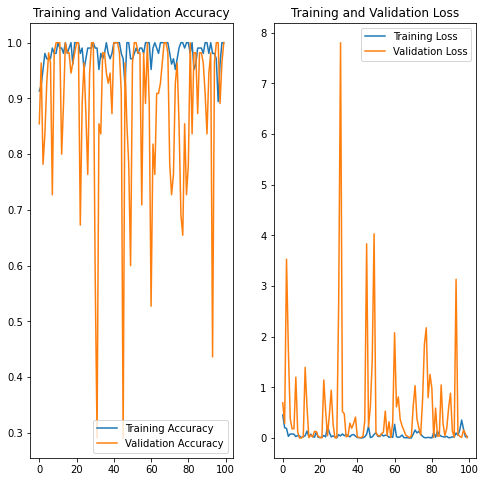

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 180, 180, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 180, 180, 3)  0           sequential_1[1][0]               
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 90, 90, 32)   896         rescaling_2[0][0]                
_______________________________________________________________________________________